In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
import matplotlib

%matplotlib inline

Using TensorFlow backend.


## data frames 

In [187]:
all_files = pd.read_csv('/home/ubuntu/git/deeplearningcourse/elizabeth/data/images_wks12/allbboxes_wks123_go_mavic.csv',index_col=[0])
#all_files = pd.read_csv('/home/ubuntu/git/deeplearningcourse/elizabeth/data/images_wks12/allbboxes_wks12_go_mavic.csv',index_col=[0])

unique_photonames = all_files.sort_index().index.unique()
#gb = all_files.mask(all_files['valid']==False).dropna()
#gb.info()


In [189]:
#path = "/home/ubuntu/git/deeplearningcourse/elizabeth/data/images_wks12/nn_above_05_weeks123_05_282.csv"
nn_df = pd.read_csv('/home/ubuntu/git/deeplearningcourse/elizabeth/data/images_wks12/nn_above_05_weeks123_batchsize1_nov16.csv',index_col=[0])
#nn_df = pd.read_csv('../../nn_output_above_05.csv',index_col=[0])
#nn_df = pd.read_csv(path)
#nn_df['xmax'] = nn_df['midx']*2-nn_df['xmin']
#nn_df['ymax'] = nn_df['midy']*2-nn_df['ymin']

#renames classes column as class to match all_boxes
nn_df.rename(columns = {'classes':'class'}, inplace = True)

#removes ".JPG"
#nn_df['photos']=nn_df['photos'].str.split('.').str.get(0)
#nn_df.sort_index().head()

#nn_df.set_index(keys='photos',inplace=True)
nn_df_conf01 = nn_df.loc[nn_df['confidence']>0.1]
nn_df_conf02 = nn_df.loc[nn_df['confidence']>0.2]
nn_df_conf03 = nn_df.loc[nn_df['confidence']>0.3]
nn_df_conf04 = nn_df.loc[nn_df['confidence']>0.4]

(nn_df_conf03.index.unique())

for i in (unique_photonames):
    if i in (nn_df_conf03.index.unique()):
        print(i)

DJI_0001_25
DJI_0001_34
DJI_0016_2
DJI_0026_10
DJI_0027_5
DJI_0029_13
DJI_0030_4
DJI_0031_6
DJI_0039_37
DJI_0040_12
DJI_0069_38
DJI_0077_21
DJI_0084_22
DJI_0097_17
DJI_0107_22
DJI_0107_24
DJI_0108_13
DJI_0110_16
DJI_0110_41
DJI_0110_6
DJI_0111_30
DJI_0116_23
DJI_0126_6
DJI_0163_9
DJI_0247_27
DJI_0292_30
DJI_0309_0
DJI_0317_22
DJI_0321_10
DJI_0321_14
DJI_0323_18
DJI_0324_8
G0013836_19
G0013841_7
G0013846_1
G0013854_2
G0013869_3
G0013877_1
G0013877_23
G0013887_7
G0024029_7
G0024031_6
G0024037_16
G0024039_10
G0024040_10
G0024043_11
G0024043_15
G0024047_13
G0024054_21
G0024058_8
G0024060_18
G0024060_8
G0024066_1
G0024068_14
G0024084_13
G0024087_5
G0036431_16
G0036437_2
G0036459_12
G0036460_17
G0036463_2
G0036508_23


In [317]:
#prec_recall = pd.DataFrame(gb)
#name = 'G0013864_8'
#num = 2
#prec_recall.loc[(name, num),('missed')]=1
#prec_recall.head()

In [222]:
#gb = all_files.mask(all_files['valid']==False).dropna().groupby('photos')
gb = all_files.groupby('photos')
#prec_recall = pd.DataFrame(all_files.mask(all_files['valid']==False).dropna())

nn_bbox = []
train_bbox = []
correct = []
mislabel = []
miss = []
done = []
false_pos = []
n = 0
m = 0
for group_name, df_truth in gb:
    try:
        
        nn_bbox = nn_df_conf02.loc[group_name][['class instances','class','xmin', 'ymin', 'xmax', 'ymax','confidence']].values
        train_bbox = df_truth.loc[group_name][['class instances','class','xmin', 'ymin', 'xmax', 'ymax']].values
        m+=1
        #reshapes for images with only 1 bbox
        if train_bbox.shape==(6,):
            train_bbox = np.reshape(train_bbox,(1,6))
            
        if nn_bbox.shape==(7,):
            nn_bbox = np.reshape(nn_bbox,(1,7))
                
        for i in train_bbox:
            bbox_true = [i[2],i[3],i[4]-i[2],i[5]-i[3]]

            for j in nn_bbox:
                
                bbox_nn = [j[2],j[3],j[4]-j[2],j[5]-j[3]]
            
                jidx = iou(bbox_true,bbox_nn)

                #true positives or mislabeled positives
                
                if jidx > .1:
                    if i[1]==j[1]:
                        #photo name, true class instance, true class, confidence
                        correct.append([group_name,i[0],i[1],j[6],jidx])
                        
                        #photo name, true class instance, true class
                        done.append([group_name,i[0],i[1]])
                    elif j[1]=='container':
                        #photo name, true class instance, true class, confidence
                        correct.append([group_name,i[0],i[1],j[6],jidx])
                        
                        #photo name, true class instance, true class
                        done.append([group_name,i[0],i[1]])
                        
                    else:
                        #true class instance, true class, nn class, confidence
                        mislabel.append([group_name,i[0],i[1],j[1],j[6],jidx])
                        
                        #photo name, true class instance, true class
                        done.append([group_name,i[0],i[1]])
                
                #false positives
                else:
                    #photo name, nn class instance, class, confidence
                    false_pos.append([group_name,j[0],j[1],j[6]])
                
            #function to calculate missed 
            if [group_name,i[0],i[1]] not in done and [group_name,i[0],i[1]] not in miss:
                miss.append([group_name,i[0],i[1]])
                       
            
        #prec_recall[(group_name),'correct'] = 1
        #prec_recall['mislabel']
        #prec_recall['miss']

    except KeyError:
        n += 1
        pass


In [225]:
correct

[['DJI_0104_5', 1, 'toy', 0.28617694999999999, 0.10778443113772455],
 ['G0013887_7', 1, 'container', 0.34170749799999994, 0.44100681699003669],
 ['G0013887_7', 4, 'container', 0.268705815, 0.689727463312369]]

In [224]:
print(len(correct),len(mislabel),len(miss))
print("ap:", len(correct)/(len(correct)+len(mislabel)))
print("recall:", len(correct)/(len(correct)+len(miss)))


3 14 175
ap: 0.17647058823529413
recall: 0.016853932584269662


In [6]:
pre_recall_bs1_05_26 = pd.DataFrame(index=[.1,.2,.3,.4,.5],columns=['correct','mislabel','miss','ap','recall','min_conf'])
pre_recall_bs1_05_26.loc[.1]=[102,426,178,.19,.36,.05]
pre_recall_bs1_05_26.loc[.2] = [51,186,217,.21,.19,.05]
pre_recall_bs1_05_26.loc[.3] = [28,81,239,.26,.10,.05]
pre_recall_bs1_05_26.loc[.4] = [13,44,258,.23,.05,.05]
pre_recall_bs1_05_26.loc[.5] = [7,27,268,.20,.03,.05]
pre_recall_bs1_05_26
#pre_recall_05_282.to_csv("precision_recall_bs1_conf05_loss26.csv")

,correct,mislabel,miss,ap,recall,min_conf
0.1,102,426,178,0.19,0.36,0.05
0.2,51,186,217,0.21,0.19,0.05
0.3,28,81,239,0.26,0.1,0.05
0.4,13,44,258,0.23,0.05,0.05
0.5,7,27,268,0.2,0.03,0.05


In [8]:
# for path = "/home/ubuntu/git/deeplearningcourse/elizabeth/data/images_wks12/nn_above_05_weeks123_05_282.csv"

pre_recall_05_282 = pd.DataFrame(index=[.1,.2,.3,.4,.5],columns=['correct','mislabel','miss','ap','recall','min_conf'])
pre_recall_05_282.loc[.1]=[260,1714,114,.13,.69,.05]
pre_recall_05_282.loc[.2] = [129,780,157,.14,.45,.05]
pre_recall_05_282.loc[.3] = [68,344,193,.17,.26,.05]
pre_recall_05_282.loc[.4] = [34,177,220,.16,.13,.05]
pre_recall_05_282.loc[.5] = [13,85,242,.13,.05,.05]
#pre_recall_05_282.to_csv("precision_recall_bs4_conf05_loss282.csv")
#len(nn_df)

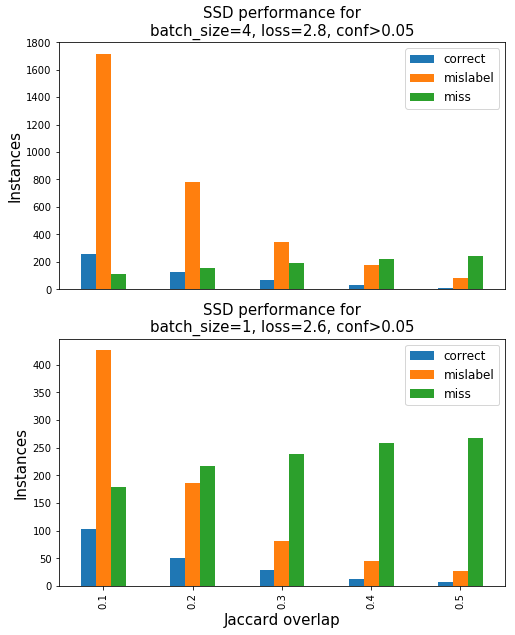

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(8,10))

pre_recall_05_282[['correct','mislabel','miss']].plot.bar(ax=axes[0])
axes[0].set_title('SSD performance for\nbatch_size=4, loss=2.8, conf>0.05',fontsize=15)
axes[0].legend(fontsize=12)
axes[0].get_xaxis().set_visible(False)
axes[0].set_ylabel('Instances',fontsize=15)
pre_recall_bs1_05_26[['correct','mislabel','miss']].plot.bar(ax=axes[1])
axes[1].set_title('SSD performance for\nbatch_size=1, loss=2.6, conf>0.05',fontsize=15)
plt.xlabel('Jaccard overlap',fontsize=15)
plt.ylabel('Instances',fontsize=15)
plt.legend(fontsize=12)

## data path

In [19]:
path_prefix = '/home/ubuntu/git/deeplearningcourse/elizabeth/data/images_wks12/images/'

## plot image

In [9]:
#image = 'G0036554_10'
photo = 'DJI_0307_6'

filepath = path_prefix+photo+'.JPG'
img = image.load_img(filepath)
img = image.img_to_array(img)
colors = plt.cm.hsv(np.linspace(0, 1, 20)).tolist()

In [11]:
#checking to see if xml files are correctly annotated

rows = all_files[all_files['photos']==photo].iterrows()

box = []
for idx, row in rows:
    x = (row['xmin'],row['ymin'],row['xmax'],row['ymax'])
    box.append(x)

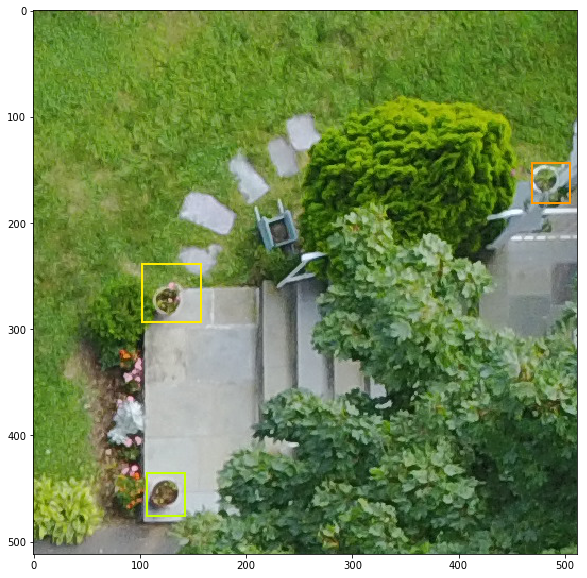

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(img/255)
currentAxis = plt.gca()


coords = (box[0][0],box[0][1]), box[0][2]-box[0][0], box[0][3]-box[0][1]
color = colors[2]
currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))

coords = (box[1][0],box[1][1]), box[1][2]-box[1][0], box[1][3]-box[1][1]
color = colors[3]
currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))

coords = (box[2][0],box[2][1]), box[2][2]-box[2][0], box[2][3]-box[2][1]
color = colors[4]
currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))

## compute jaccard

In [48]:
x1 = np.max([xmin, xmin2]) #max of xmins between 2 boxes
y1 = np.max([ymin, ymin2]) #max of ymins between the 2 boxes
x2 = np.min([xmax, xmax2]) #min of ymaxes between two boxes
y2 = np.min([ymax, ymax2]) #min of ymaxes bewtween 2 boxes

print('box 1: ',xmin, ymin, xmax, ymax)
print('box 2: ',xmin2, ymin2, xmax2, ymax2)

inter = (y2 - y1)*(x2 - x1)
aarea = (ymax-ymin)*(xmax-xmin)
barea = (ymax2-ymin2)*(xmax2-ymin2)

iou = inter / (aarea+barea-inter)

iou

box 1:  10 10 110 110
box 2:  40 40 210 210


## define jaccard

In [206]:
def iou(box1,box2,class1='ignore',class2='ignore'):
    '''
    Defines the intersection over union, also known as the Jaccard index, for the given boxes
    
    Inputs (arrays/lists and string):
    
    Box i = (xmin, ymin, width, height)
    Class i = class of box 
    
    Returns (float)
    
    intersection over union = intersection of the two boxes / summed area of thoses boxes 
    '''
    
    if class1 != class2:
        print("Classes not the same; do not compute iou")
        
    else:
        
        
        x1 = np.max([box1[0], box2[0]]) #max of xmins between 2 boxes
        y1 = np.max([box1[1], box2[1]]) #max of ymins between the 2 boxes
        x2 = np.min([(box1[0]+box1[2]), (box2[0]+box2[2])]) #min of xmaxes between two boxes
        y2 = np.min([(box1[1]+box1[3]), (box2[1]+box2[3])]) #min of ymaxes bewtween 2 boxes
        
        #max is for any non overlapping boxes
        intersection = max(0,(y2 - y1+1))*max(0,(x2 - x1)+1)
        b1_area = box1[2]*box1[3]
        b2_area = box2[2]*box2[3]

        iou = intersection / (b1_area+b2_area-intersection)
    
    
    return iou

## use jaccard to determine whether boxes should be kept

In [ ]:
'''# inspired by https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/
# which was inspired by Felzenszwalb et al.

def max_suppression(coords):
    '''
        Takes in an array of boxes of the same class from the same photo
        Iterates through and keeps the box with the higheset confidence if the overlap is greater than .3
        
        Input (np array):
            [xmin,ymin,width,height,confidence]
            each index refers to a different instance of objct; should all be the same size
            
        Outputs (list of lists)
    '''
    thresh = .3
    
    #if only one box of that type, return that box
    if len(coords[1]) == 1:
        return coords
    
    keep = []
    
    xmin = coords[0]
    xmax = coords[0] + coords[2]
    ymin = coords[1]
    ymax = coords[1] + coords[3]
    width = coords[2]
    height = coords[3]
    
    area = height*width
    
    #sort by confidence level
    conf_idx = np.argsort(coords[4])
    
    #start with least confident
    
    while len(conf_idxs) > 0:
        
        last = len(conf_idx) - 1
        box1 = conf_idx[last]
        keep.append(box1) #keeps highest confidence box
        suppress = [last] #might change this
        
        for p in range(0,last):
            
            box2 = conf_idx[p]
            
            

            j = jaccard((),())
            

#difficulty -> what to do about different objects of same class? 


#taken from SSD-TENSORFLOW / nets / np_methods

def bboxes_nms(classes, scores, bboxes, nms_threshold=0.45):
    """Apply non-maximum selection to bounding boxes.
    """
    keep_bboxes = np.ones(scores.shape, dtype=np.bool)
    for i in range(scores.size-1):
        if keep_bboxes[i]:
            # Computer overlap with bboxes which are following.
            overlap = bboxes_jaccard(bboxes[i], bboxes[(i+1):])
            # Overlap threshold for keeping + checking part of the same class
            keep_overlap = np.logical_or(overlap < nms_threshold, classes[(i+1):] != classes[i])
            keep_bboxes[(i+1):] = np.logical_and(keep_bboxes[(i+1):], keep_overlap)

    idxes = np.where(keep_bboxes)
    return classes[idxes], scores[idxes], bboxes[idxes]
'''

## apply to dataframes 

#### Part 1: peform maximum suppression within nn_validation output 

for each instance (index) of each object type (index) in each photo (index):
1. compute iou
2. if iou > .3 == same object
3. keep the entry with the highest confidence

#### Part 2: comparing nn_validation output with validation set

after removing duplicates (above)
for each instance (index) of each object type (index) in each photo (index):
1. compute iou
2. if iou > 50 == succesfully id
    1. track
      1. number of validated objects found, by class
      2. number of validated objects not found, by class
      3. number of nn objects with 0 overlap with validation set

nn_df, val_df  = pandas df indexed by photo, class, instance number with cols xmin, ymin, width, height

In [87]:
nn_df.head()

class   midx   midy   xmin   ymin  height  \
photos     class instances                                                
G0024084_1 1                    pot  495.5  313.5  481.0  298.0   512.0   
           1                clutter  288.5  437.5  119.0  395.0   512.0   
           2                clutter  155.5  446.5    9.0  385.0   512.0   
           3                clutter  238.0  459.5  125.0  415.0   512.0   
           4                clutter  339.0  440.0  269.0  390.0   512.0   

                            width  confidence   xmax   ymax  
photos     class instances                                   
G0024084_1 1                512.0    0.116554  510.0  329.0  
           1                512.0    0.160757  458.0  480.0  
           2                512.0    0.090801  302.0  508.0  
           3                512.0    0.078253  351.0  504.0  
           4                512.0    0.073206  409.0  490.0

### current testing

In [59]:
nn_slice = nn_df.iloc[1:100]
for i in nn_df.index.unique():
    if i.startswith('G002408'):
        print(i)

G0024084_1
G0024080_22
G0024087_4
G0024084_2
G0024088_10
G0024087_22
G0024085_22
G0024084_3


In [61]:
#gets all index values from all_files
for i in all_files.index.get_values():
    if i.startswith('G0024080'):
        print(i)

G0024080_22
G0024080_14
G0024080_14
G0024080_14
G0024080_14
G0024080_14
G0024080_2
G0024080_2
G0024080_2


In [70]:
file = 'G0024080_22'

np.isin(file,all_files.index.get_values())

array(True, dtype=bool)

In [100]:
all_files

,class,class instances,xmid,ymid,xmin,ymin,xmax,ymax,iwidth,iheight,valid
photos,,,,,,,,,,,
G0024066_1,trash,1,249.0,441.5,183.0,408.0,315.0,475.0,512.0,512.0,True
DJI_0034_2,tarp,1,244.0,427.0,172.0,342.0,316.0,512.0,512.0,512.0,False
G0036554_10,container,1,320.5,244.5,299.0,223.0,342.0,266.0,512.0,512.0,False
G0036554_10,container,2,333.0,222.0,319.0,208.0,347.0,236.0,512.0,512.0,False
G0036554_10,air conditioner,3,457.5,261.5,421.0,228.0,494.0,295.0,512.0,512.0,False
G0036452_15,container,1,283.5,23.0,266.0,10.0,301.0,36.0,512.0,512.0,False
G0036452_15,ladder,2,390.5,193.0,269.0,129.0,512.0,257.0,512.0,512.0,False
DJI_0302_13,trash bin,1,273.5,307.5,231.0,258.0,316.0,357.0,512.0,512.0,False
G0024017_5,pool,1,221.0,287.5,79.0,63.0,363.0,512.0,440.0,512.0,False


In [101]:
val_bboxes = []
nn_bboxes = []

for f in all_files.index.get_values():
    if f==file:
        all_slice = all_files.loc[f]
        nn_slice = nn_df.loc[f]
        
        #works if you keep as dictionary
        #for idx, row in all_slice.iterrows():
            #val_bboxes.append([row['xmin'],row['ymin'],(row['midx']*2-row['xmin']),(row['midy']*2-row['ymin']),row['class']])
        
        try:
            for i,val in enumerate(all_slice['xmin']):
                val_bboxes.append([all_slice['xmin'],all_slice['ymin'],(all_slice['xmin']*2-all_slice['xmin']),
                                 (all_slice['ymin']*2-all_slice['ymin']),all_slice['class']])
        except TypeError:
            val_bboxes.append([all_slice['xmin'],all_slice['ymin'],(all_slice['xmin']*2-all_slice['xmin']),
                                 (all_slice['ymin']*2-all_slice['ymin']),all_slice['class']])
            
        try:
            for i,val in enumerate(nn_slice['xmin']):
                nn_bboxes.append([nn_slice['xmin'],nn_slice['ymin'],(nn_slice['xmin']*2-nn_slice['xmin']),
                                 (nn_slice['ymin']*2-nn_slice['ymin']),nn_slice['classes']])
        except TypeError:
            nn_bboxes.append([nn_slice['xmin'],nn_slice['ymin'],(nn_slice['xmin']*2-nn_slice['xmin']),
                                     (nn_slice['ymin']*2-nn_slice['ymin']),nn_slice['classes']])

In [106]:
for x in nn_slice.iteritems():
    print(x)

('classes', photos
G0024080_22           pot
G0024080_22         table
G0024080_22         table
G0024080_22         table
G0024080_22    flower pot
G0024080_22    flower pot
G0024080_22    flower pot
G0024080_22    flower pot
G0024080_22    flower pot
G0024080_22    flower pot
G0024080_22    flower pot
G0024080_22    flower pot
G0024080_22    flower pot
G0024080_22    flower pot
G0024080_22    flower pot
G0024080_22    flower pot
G0024080_22    flower pot
G0024080_22    flower pot
G0024080_22    flower pot
G0024080_22    flower pot
G0024080_22    flower pot
G0024080_22    flower pot
G0024080_22    flower pot
G0024080_22         porch
G0024080_22         porch
G0024080_22         porch
G0024080_22         porch
G0024080_22         porch
G0024080_22         porch
G0024080_22         porch
                  ...    
G0024080_22     container
G0024080_22     container
G0024080_22     container
G0024080_22     container
G0024080_22     container
G0024080_22     container
G0024080_22     con

### trying out iterrows

In [128]:
s = nn_df.iloc[1:50]

f = 'G0024047_13'
c = 'porch'

x = nn_df.loc[(f,c)]

bboxes = []

for idx, row in x.iterrows():
    bboxes.append([row['xmin'],row['ymin'],(row['midx']*2-row['xmin']),(row['midy']*2-row['ymin']),row['class']])
    #overlap = bboxes_jaccard(bboxes[i], bboxes[(i+1):])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  


In [129]:
bboxes

[[349.0, 72.0],
 [26.0, 89.0],
 [10.0, 6.0],
 [49.0, 12.0],
 [376.0, 5.0],
 [419.0, 95.0],
 [40.0, 56.0],
 [3.0, 152.0],
 [120.0, 30.0],
 [22.0, 16.0],
 [369.0, 272.0],
 [316.0, 57.0],
 [319.0, 0.0],
 [8.0, 208.0],
 [2.0, 65.0],
 [344.0, 180.0]]

In [37]:
#nn_df.reset_index(level="class instances",inplace=True)
s = nn_df.iloc[1:50]
grouped = s.groupby(by=['photos','classes'])
grouped['confidence'].agg('max')


photos      classes   
G0024084_1  clutter       0.160757
            flower pot    0.332006
            porch         0.110211
            table         0.197499
Name: confidence, dtype: float64

In [56]:
s = nn_df.iloc[1:50]
s['sum'] = s.xmin - s.xmin.shift()#.shift()

#didn't work to do comparisons in later rows
#s['sum'] = s.xmin - s.xmin.shift().shift()
#s['sum'] = s.xmin - s.xmin.shift(period=2)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [57]:
s = nn_df.iloc[1:50]
s['sum'] = s.apply(lambda x: x.xmin + x.ymin, axis=1)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [77]:
s = nn_df.iloc[1:50]
grouped = s.groupby(by=['photos','classes'])
for name, g in grouped:
    for idx, row in g.iterrows():
        print (row)

classes             clutter
class instances           1
midx                  288.5
midy                  437.5
xmin                    119
ymin                    395
height                  512
width                   512
confidence         0.160757
Name: G0024084_1, dtype: object
classes              clutter
class instances            2
midx                   155.5
midy                   446.5
xmin                       9
ymin                     385
height                   512
width                    512
confidence         0.0908007
Name: G0024084_1, dtype: object
classes              clutter
class instances            3
midx                     238
midy                   459.5
xmin                     125
ymin                     415
height                   512
width                    512
confidence         0.0782533
Name: G0024084_1, dtype: object
classes              clutter
class instances            4
midx                     339
midy                     440
xmin          

In [62]:
pd.set_option('max_rows',200)
nn_df[200:400]

,classes,class instances,midx,midy,xmin,ymin,height,width,confidence
photos,,,,,,,,,
G0024047_13,table,12,231.0,84.0,187.0,3.0,512.0,512.0,0.105540
G0024047_13,flower pot,1,115.0,64.0,98.0,50.0,512.0,512.0,0.189758
G0024047_13,flower pot,2,74.5,410.5,57.0,392.0,512.0,512.0,0.156935
G0024047_13,flower pot,3,97.5,169.5,88.0,153.0,512.0,512.0,0.151523
G0024047_13,flower pot,4,98.5,182.0,88.0,167.0,512.0,512.0,0.132453
G0024047_13,flower pot,5,89.5,168.5,79.0,155.0,512.0,512.0,0.113707
G0024047_13,flower pot,6,77.0,398.0,63.0,381.0,512.0,512.0,0.106665
G0024047_13,flower pot,7,181.5,104.0,170.0,88.0,512.0,512.0,0.106066
G0024047_13,flower pot,8,31.0,115.5,18.0,101.0,512.0,512.0,0.105856


In [54]:
#for f in nn_df.index.get_level_values('photos').unique():
    #if f == 'G0024047_13':
x = nn_df.loc[(nn_df.index.get_level_values('photos')=='G0024047_13') & (nn_df.index.get_level_values('classes')=='porch')]['xmin']
x2 = nn_df.loc[((nn_df.index.get_level_values('photos')=='G0024047_13') & (nn_df.index.get_level_values('classes')=='porch')),'xmin']
y = nn_df.loc[(nn_df.index.get_level_values('photos')=='G0024047_13') & (nn_df.index.get_level_values('classes')=='porch')]['ymin']
w = nn_df.loc[(nn_df.index.get_level_values('photos')=='G0024047_13') & (nn_df.index.get_level_values('classes')=='porch')]['width']
h = nn_df.loc[(nn_df.index.get_level_values('photos')=='G0024047_13') & (nn_df.index.get_level_values('classes')=='porch')]['height']

f = 'G0024047_13'
c = 'porch'

h2 = nn_df.loc[f,c]['height']

test_sum = h2 + w
test_list = [x,y,w,h]
#for i in nn_df[(nn_df.index.get_level_values('photos')=='G0024047_13') & 
#                   (nn_df.index.get_level_values('classes')=='porch')]:
#    print(i)
    #print(nn_df[(nn_df.index.get_level_values('photos')=='G0024047_13') & 
                #(nn_df.index.get_level_values('classes')=='porch') &


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  if sys.path[0] == '':


In [109]:
f = 'G0024047_13'
c = 'porch'

x = nn_df.loc[(f,c),'xmin'].tolist()
y = nn_df.loc[(f,c),'ymin'].tolist()
h = nn_df.loc[(f,c),'height'].tolist()
w = nn_df.loc[(f,c),'width'].tolist()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1325: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [114]:
#for photo in pd
    #for class in photo
        #x = nn_df.loc[(f,c),'xmin'].tolist()
        #y = nn_df.loc[(f,c),'ymin'].tolist()
        #h = nn_df.loc[(f,c),'height'].tolist()
        #w = nn_df.loc[(f,c),'width'].tolist()

        #data = np.asarray([x,y,w,h])
        
        
len(data[1])

16

## Dicts do not work

In [92]:
nn_dict = nn_df.to_dict('split')

In [93]:
nn_dict

{'columns': ['classes',
  'class instances',
  'midx',
  'midy',
  'xmin',
  'ymin',
  'height',
  'width',
  'confidence'],
 'data': [['pot',
   1,
   495.5,
   313.5,
   481.0,
   298.0,
   512.0,
   512.0,
   0.11655367910861968],
  ['clutter', 1, 288.5, 437.5, 119.0, 395.0, 512.0, 512.0, 0.1607566922903061],
  ['clutter', 2, 155.5, 446.5, 9.0, 385.0, 512.0, 512.0, 0.0908006876707077],
  ['clutter',
   3,
   238.0,
   459.5,
   125.0,
   415.0,
   512.0,
   512.0,
   0.07825334370136261],
  ['clutter',
   4,
   339.0,
   440.0,
   269.0,
   390.0,
   512.0,
   512.0,
   0.07320554554462433],
  ['table', 1, 50.5, 362.0, 8.0, 334.0, 512.0, 512.0, 0.19749926030635834],
  ['table', 2, 379.0, 429.0, 320.0, 377.0, 512.0, 512.0, 0.10461820662021636],
  ['table', 3, 339.0, 440.0, 269.0, 390.0, 512.0, 512.0, 0.0818115621805191],
  ['table', 4, 232.5, 431.5, 182.0, 376.0, 512.0, 512.0, 0.08014050126075745],
  ['table', 5, 287.0, 431.0, 232.0, 376.0, 512.0, 512.0, 0.0755411833524704],
  ['flow

In [85]:
nn_dict.keys()
nn_dict.values()

dict_values([{'classes': 'container', 'class instances': 51, 'midx': 217.0, 'midy': 326.0, 'xmin': 181.0, 'ymin': 307.0, 'height': 512.0, 'width': 512.0, 'confidence': 0.06988848000764848}, {'classes': 'chair', 'class instances': 61, 'midx': 302.0, 'midy': 236.0, 'xmin': 285.0, 'ymin': 216.0, 'height': 512.0, 'width': 512.0, 'confidence': 0.1053415834903717}, {'classes': 'container', 'class instances': 65, 'midx': 479.5, 'midy': 254.0, 'xmin': 447.0, 'ymin': 227.0, 'height': 512.0, 'width': 512.0, 'confidence': 0.06958580017089844}, {'classes': 'container', 'class instances': 81, 'midx': 71.5, 'midy': 427.5, 'xmin': 57.0, 'ymin': 417.0, 'height': 512.0, 'width': 512.0, 'confidence': 0.07185204327106476}, {'classes': 'container', 'class instances': 83, 'midx': 279.5, 'midy': 92.5, 'xmin': 271.0, 'ymin': 81.0, 'height': 512.0, 'width': 512.0, 'confidence': 0.08613904565572739}, {'classes': 'chair', 'class instances': 65, 'midx': 170.5, 'midy': 194.0, 'xmin': 130.0, 'ymin': 162.0, 'height

In [91]:
nn_dict['G0013846_2']

{'class instances': 85,
 'classes': 'container',
 'confidence': 0.08361078053712845,
 'height': 512.0,
 'midx': 293.0,
 'midy': 308.5,
 'width': 512.0,
 'xmin': 283.0,
 'ymin': 298.0}

## Shading

In [1]:
shade = {"full shade":[["visible",13],("unknown",6),("not visible", 25)],
        "partial shade": [["visible",19],("unknown",7),("not visible", 40)],
        "no shade": [["visible",6],("unknown",5),("not visible", 13)]}

shade2 = {"full shade":[13,6,25],"no shade":[6,5,13],"partial shade":[19,7,40]}

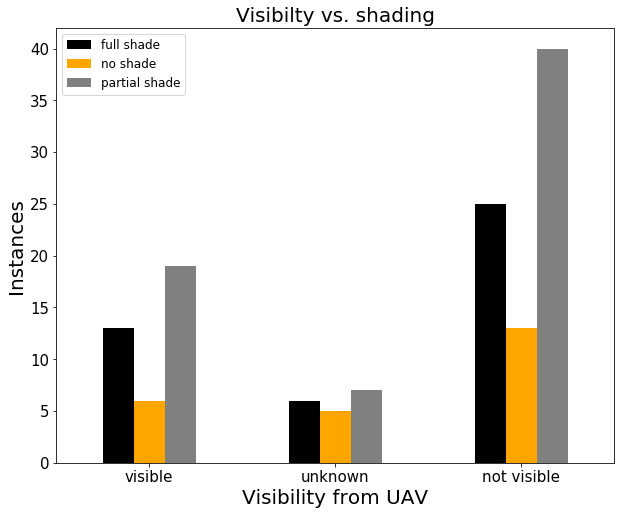

In [30]:

sh_df = pd.DataFrame(shade2,index=["visible","unknown","not visible"])
x = matplotlib.colors.ListedColormap(["black","orange","gray"], name='shaded_colors')
#my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)
plt.figure(figsize=(10,10))
sh_df.plot.bar(cmap=x,figsize=(10,8))
plt.ylabel("Instances",fontsize=20)
plt.xlabel("Visibility from UAV",fontsize=20)
plt.title("Visibilty vs. shading",fontsize=20)
plt.xticks(rotation=0,fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=12)

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as color
%matplotlib inline



In [4]:
print('visible, no shade/full shade', 6./13)
print('visible, full/partial shade', 13./19)
print('visible, full/shade', 6./(13+19))

print('not visible, no shade/full shade', 13./25)
print('not visible, full/partial shade', 25./40)
print('not visible, full/shade', 13./(25+40))

visible, no shade/full shade 0.46153846153846156
visible, full/partial shade 0.6842105263157895
visible, full/shade 0.1875
not visible, no shade/full shade 0.52
not visible, full/partial shade 0.625
not visible, full/shade 0.2
